In [73]:
#Imports
import geopandas as gpd
from shapely.geometry import Point, Polygon 
import geopy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

#drive time
import osmnx as ox
import networkx as nx
import pyproj

In [74]:
# Data import for Wisconsin Shape and Counties
counties_GDF = gpd.read_file("data/counties.geojson") #population and boundaries of each county in Wisconsin
counties_GDF.head()


,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


In [75]:
# Create a new column without the word "County" - Useful later for merging with zip code
counties_GDF['NAME_only'] = counties_GDF['NAME'].str.replace(' County', '')
counties_GDF.tail()

,NAME,POP100,geometry,NAME_only
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",Washburn
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",Monroe
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",Richland
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830...",Price
71,St. Croix County,84345,"POLYGON ((-92.51872 45.20963, -92.52951 45.209...",St. Croix


In [6]:
#Bring in data for all Wisconsin Lake shapes - large file, takes some time
lakes_GDF = gpd.read_file("data/AllWisconsinLak/wiscoNoZ_wgs84/wiscoNoZ_wgs84.shp")

In [7]:
#Grab only great lakes info 
lakes_GDF.head()
lake_mich =lakes_GDF[lakes_GDF['WBDY_NAME'] == 'Lake Michigan']
lake_sup = lakes_GDF[lakes_GDF['WBDY_NAME'] == 'Lake Superior']


In [8]:
#bring in zip code data
zips_df = pd.read_csv('data/ZIP Codes by Rural and Urban Groupings Appendix.csv') #file contains all wisconsin county zip codes and urban/rural groupings
zips_gdf = gpd.read_file("data/2010_zctas_zip/tl_2010_55_zcta510.shp") #shpae file with zip code shapes for plotting


In [9]:
#Cleaning up zips_df
zips_df.loc[(zips_df['Wisconsin Rural and Urban Groupings'] == 'PO Box') | \
            (zips_df['Wisconsin Rural and Urban Groupings'] == 'Organization') | \
            (zips_df['Wisconsin Rural and Urban Groupings'] == 'Population <500'), 'Wisconsin Rural and Urban Groupings'] = 'N/A' #Selects all for PO Box, Organization, and Population<500 and makes value N/A
zips_df.head()

,Wisconsin Rural and Urban Groupings,ZIP Code,County Name
0,Urban Underserved,53140,Kenosha
1,Urban Underserved,53143,Kenosha
2,Urban Underserved,53172,Milwaukee
3,Urban Underserved,53204,Milwaukee
4,Urban Underserved,53205,Milwaukee


In [10]:
#Cleaning up zips_gdf
zips_gdf =zips_gdf.rename(columns={'ZCTA5CE10':'ZIP Code'}) #rename to Zip Code for clarity
zips_gdf['ZIP Code'] = zips_gdf['ZIP Code'].astype('int64') #set data type to int
zips_gdf.head()

,STATEFP10,ZIP Code,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,55,53965,5553965,B5,G6350,S,438395910,12495529,+43.6714224,-089.7481343,N,"POLYGON ((-89.73877 43.59807, -89.73879 43.598..."
1,55,54943,5554943,B5,G6350,S,317698373,1717398,+44.1328138,-089.5904104,N,"MULTIPOLYGON (((-89.44567 44.03308, -89.44822 ..."
2,55,54966,5554966,B5,G6350,S,207699645,816111,+44.2100191,-089.5048880,N,"MULTIPOLYGON (((-89.54891 44.27173, -89.54900 ..."
3,55,54546,5554546,B5,G6350,S,558090328,6314915,+46.2996722,-090.6947205,N,"POLYGON ((-90.70420 46.24142, -90.71063 46.241..."
4,55,54559,5554559,B5,G6350,S,355016441,4131506,+46.4952083,-090.4912294,N,"POLYGON ((-90.34031 46.46557, -90.34036 46.459..."


In [11]:
#combine the two zip code datasets for plotting
zips_plotting = pd.merge(zips_df, zips_gdf[['ZIP Code', 'geometry']], on='ZIP Code', how='outer')
zips_plotting = gpd.GeoDataFrame(zips_plotting, geometry='geometry')
zips_plotting.head()

,Wisconsin Rural and Urban Groupings,ZIP Code,County Name,geometry
0,Urban Underserved,53140,Kenosha,"POLYGON ((-87.84495 42.59286, -87.84540 42.592..."
1,Urban Underserved,53143,Kenosha,"POLYGON ((-87.81196 42.56568, -87.80919 42.565..."
2,Urban Underserved,53172,Milwaukee,"POLYGON ((-87.85962 42.89332, -87.86040 42.893..."
3,Urban Underserved,53204,Milwaukee,"POLYGON ((-87.91872 43.03394, -87.91872 43.034..."
4,Urban Underserved,53205,Milwaukee,"POLYGON ((-87.92572 43.04576, -87.92588 43.045..."


In [12]:
#Bring in Clinic netwrok data with addresses from facesheet
clinic_df = pd.read_csv('data/WAIClinicsFacesheet-Clinics_Export.csv')

In [13]:
#Clean up clinic_df - select only active clinics
clinic_df = clinic_df[clinic_df['status'] == 1]
clinic_df.head()

### Suite 508 in the address of 22 (Waukesha 721 American Ave) causes problems/cannot be plotted, I manually took that part of the address out in the csv/excel file

,record_id,redcap_event_name,clinic_name,status,clinic_address,city,zipcode,md_name,med_area
0,1,event_1_arm_1,Aurora Two Rivers Memory Assessment Clinic,1,2219 Garfield Street,Two Rivers,54241-2416,"Tracy Sherman, MD",1
1,2,event_1_arm_1,Center for Senior Health and Longevity - Milwa...,1,1020 N. 12th Street,Milwaukee,53233-1308,"Richard London, MD; Mike Malone, MD; Marc Rasa...",1
2,3,event_1_arm_1,Center for Senior Health and Longevity at Summit,1,36500 Aurora Drive,Oconomowoc,53066-4899,"Soryal Soryal, MD",1
3,4,event_1_arm_1,Door County Memory Care,1,323 S. 18th Street,Sturgeon Bay,54235-1401,"Paul Board, MD",4
4,5,event_1_arm_1,Essentia Health - Ashland Memory Clinic,1,1625 Maple Lane,Ashland,54806-3768,"Kim Ogle, MD",4


In [14]:
### Efficient Methodology adapted from ChatGPT prompt - Prepping clinic gdf for plotting on map 

# Format the address strings into ['formatted_address'] format
#Then use geopy (turn dataframe into geodataframe, use the address in formatted_address to get the point locations for clinics). This is sometimes a little problematic, you may get errors. 
    #To fully understand it is necessary to go to API website and read the rules. I usually just run this code once, then comment it out and make sure not to change clinic_gdf.
#Finally, assign the geometry points to the right coord system


for row in clinic_df.iterrows():
    clinic_df['formatted_address'] = clinic_df.apply(lambda row: f"{row['clinic_address']}, {row['city']}, WI {row['zipcode']}, United States", axis=1)
    
# clinic_gdf = gpd.tools.geocode(clinic_df['formatted_address'], user_agent = "WAIAgent") #this is the line not to run often. 
clinic_gdf = clinic_gdf.rename(columns = {'address':'formatted_address'})


### DO NOT run super frequently, there are limits and rules for API website ###

In [15]:
clinic_gdf

,geometry,formatted_address
0,POINT (-87.55766 44.15443),"Aurora Two Rivers Clinic, 2219, Garfield Stree..."
1,POINT (-87.91022 43.04409),"1000 North Water Street, 1020, North Water Str..."
2,POINT (-88.46814 43.06586),"Aurora Medical Center, 36500, Aurora Drive, 53..."
3,POINT (-87.38028 44.83240),"Sturgeon Bay Bridge, Michigan Street, 54235, M..."
4,POINT (-90.87046 46.62813),"Ashland Harbor Breakwater Light, Lake Shore Dr..."
6,POINT (-88.07065 43.14407),"Northfield Drive, 53052, Menomonee Falls, Wisc..."
7,POINT (-88.02159 43.04652),"Wisconsin Athletic Club, 8700, West Watertown ..."
8,POINT (-88.02456 43.04140),"Froedtert Hospital, 9200, West Wisconsin Avenu..."
9,POINT (-87.95969 44.47296),"Wandering Springs Estates, 54311, Green Bay, W..."
10,POINT (-91.24663 43.79307),"Gundersen Lutheran Medical Center, 1900, South..."


In [16]:
#merge the clinic geodataframe with the point locations to the clinic dataframe with info, med_area, etc.
merged_clinic_df = clinic_df.join(clinic_gdf[['geometry']])
#set back to geodataframe object
merged_clinic_gdf = gpd.GeoDataFrame(merged_clinic_df, geometry = 'geometry')


In [93]:
#set the correct coordinate system for wisconsin and apply to all gdfs
counties_GDF = counties_GDF.to_crs('EPSG:4326')
lake_michigan = lake_mich.to_crs(counties_GDF.crs)
lake_superior = lake_sup.to_crs(counties_GDF.crs)
zips_gdf = zips_gdf.to_crs(counties_GDF.crs)
zips_plotting = zips_plotting.to_crs(counties_GDF.crs)
merged_clinic_gdf = merged_clinic_gdf.to_crs(counties_GDF.crs)


In [94]:
#make one lakes gdf for ease of plotting
great_lakes = pd.concat([lake_michigan, lake_superior])

In [95]:
# Creates a dictionary with separate GeoDataFrames for each med_area (diff colors on map)
med_area_dfs = {med_area: merged_clinic_gdf[merged_clinic_gdf['med_area'] == med_area].copy() for med_area in merged_clinic_gdf['med_area'].unique()}
med_area_dfs.keys() #Each key corresponds to a dataframe of only that clinic specialty

dict_keys(['1', '4', '5', '2', '1,5', '3'])

In [96]:
## Creating unique data frames for each clinic specialty to avoid errors or the need to remember the specific number to use as the key for med_area_dfs
# Geriatrics == 1
geriatric_clinics = med_area_dfs['1']
# Neurology == 2
neurology_clinics = med_area_dfs['2']
# Family Medicine == 3
family_clinics = med_area_dfs['3']
# Internal Medicine == 4
internal_clinics = med_area_dfs['4']
# Psychiatry == 5
psychiatry_clinics = med_area_dfs['5']
## What to do about multiple specialty clinics? - plot as multiple
# Multiple == 1,5 # if there are more combinations in the future, create multiple dfs and merge them with multiple clinics
multiple_clinics =  med_area_dfs['1,5']

In [97]:
# neurology_clinics

In [98]:
## Create separate GeoDataFrames for each zip grouping (for diff colors on map)
# this is set up like the previous dictionary of dataframes, but since the key for each is the grouping, I chose not to assign each a variable name
zip_area_dfs = {zip_area: zips_plotting[zips_plotting['Wisconsin Rural and Urban Groupings'] == zip_area].copy() for zip_area in zips_plotting['Wisconsin Rural and Urban Groupings'].unique()}
zip_area_dfs.keys() #different groupings


dict_keys(['Urban Underserved', 'Urban Advantaged', 'Urban', 'Rural Underserved', 'Rural Advantaged', 'Rural', 'N/A'])

In [99]:
## Creating a custom colormap

bounds = np.arange(0, 8)  # Assuming you have 7 categories (0 to 7), sets the number of categories

c = np.zeros((256,4)) #matrix of size 256x4, all zeroes
#set specific colors
#numbers inside list are in RGBA format converted from hexcodes given to me by Uriel or found on google chrome color tool
c[3] = [0.9568627450980393, 0.6431372549019608, 0.6431372549019608,1] #f4a4a4   #muted red
c[2] = [1,0.6941176470588235,0.6,1] #FFB199   #orangey red
c[1] = [0.9686274509803922,0.803921568627451,0.7450980392156863,1] #f7cdbe #light red/orange

c[6] = [0.5137254901960784,0.6823529411764706,0.9372549019607843,1] #83AEEF   #indigo blue
c[5] = [0.6392156862745098,0.8431372549019608,1,1] # A3D7FF    #light blue
c[4] = [0.8705882352941177,0.9333333333333333,0.9882352941176471,1] #deeefc    #white blue

c[0] = [0.99, 0.99, 0.99, 1]  # Off-white color

custom_cmap = ListedColormap(c)

norm = BoundaryNorm(bounds, len(bounds) - 1) #argument used to pass into plot function that allows color map to assign to the different categories

[Text(0, 41.0, ''),
 Text(0, 42.0, ''),
 Text(0, 43.0, ''),
 Text(0, 44.0, ''),
 Text(0, 45.0, ''),
 Text(0, 46.0, ''),
 Text(0, 47.0, ''),
 Text(0, 48.0, '')]

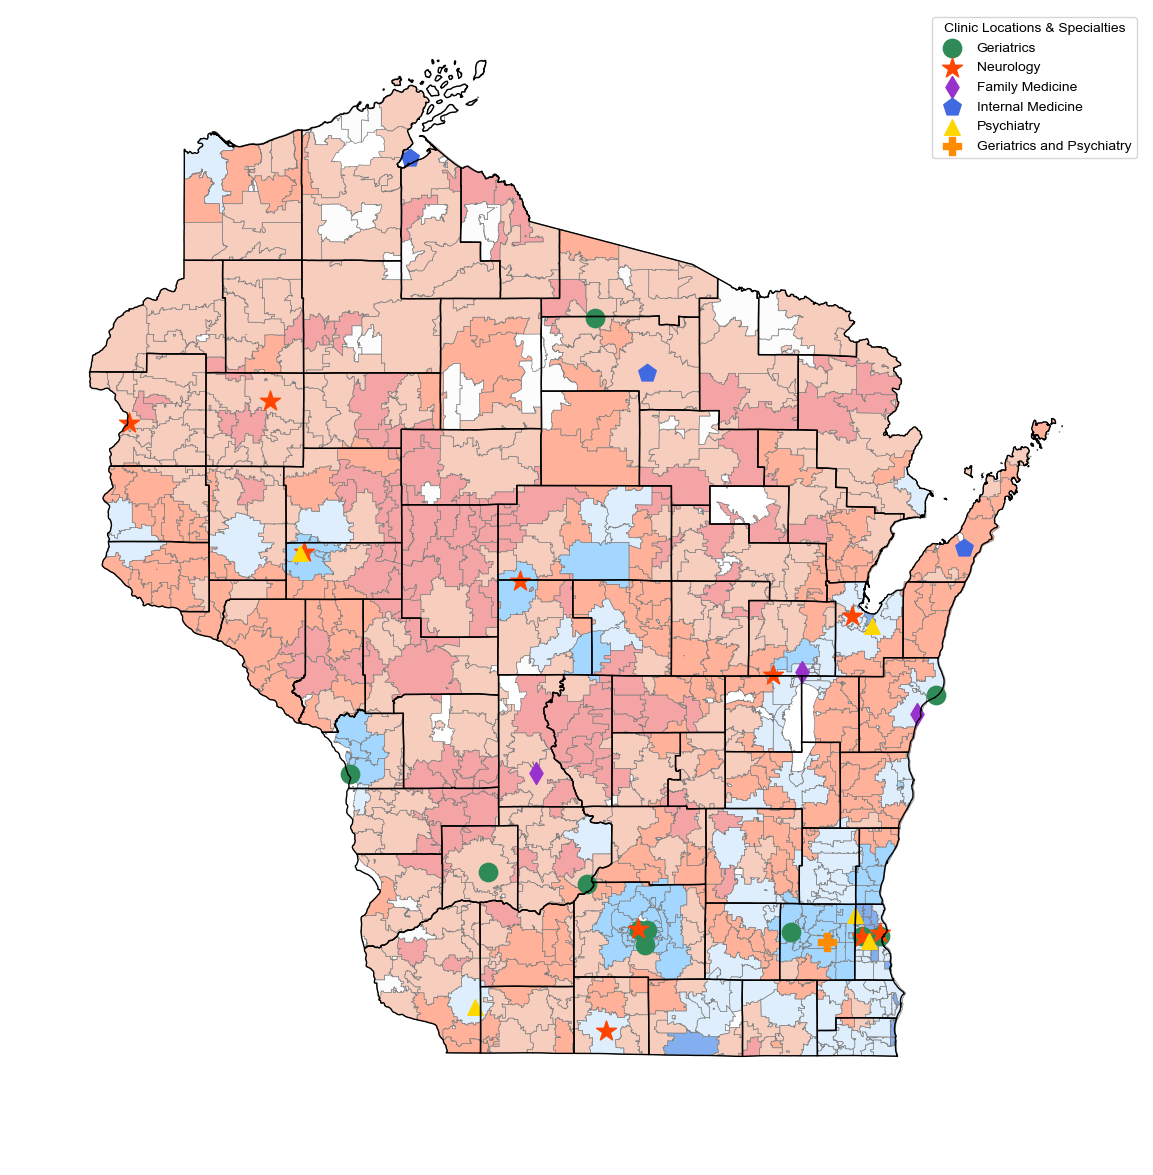

In [146]:
### Final Product ###

# Set plot size and and background color
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('white')



## Plot wisconsin with great lakes cutout to get accurate county and state shape

#create a mask to get specific wisco shape with create lakes cutouts
wisc_mask = gpd.overlay(counties_GDF, great_lakes, how = 'difference')

# Plot lakes only where they intersect with Wisconsin
wisc_mask.boundary.plot(ax=ax, color='black', linewidth = 1)


# Get the bounding box of the counties_GDF (wisco shape)
xmin, ymin, xmax, ymax = counties_GDF.total_bounds 

## Plot zip codes and clinics

# Plot zipcodes - diff colors by category (legent=True allowed me to get a legend for the zip code areas, but I could not customize it at all or add a title
zips_plotting.plot(ax=ax, column ='Wisconsin Rural and Urban Groupings',linewidth=.5, edgecolor= 'grey', cmap=custom_cmap, legend = True, norm=norm)

#plot clinics - different colors and shapes by specialty
geriatric_clinics.plot(ax = ax, color = 'seagreen', markersize=175 , marker = 'o', label='Geriatrics')
neurology_clinics.plot(ax = ax, color = 'orangered', markersize=225 ,  marker = '*', label='Neurology')
family_clinics.plot(ax = ax, color = 'darkorchid', markersize=125 , marker = 'd', label='Family Medicine')
internal_clinics.plot(ax = ax, color = 'royalblue', markersize=175 , marker = 'p', label='Internal Medicine')
psychiatry_clinics.plot(ax = ax, color = 'gold', markersize=125 , marker = '^', label='Psychiatry')
multiple_clinics.plot(ax = ax, color = 'darkorange', markersize=175 , marker = 'P', label='Geriatrics and Psychiatry')


# Create PLot Legend - I could only ever get one at a time, so modified this to get multiple
clinic_legend = ax.legend(loc='upper right')
clinic_legend.set_title('Clinic Locations & Specialties')

#Set font to Arial
plt.rc('font', family='Arial')


# Set the xlim and ylim based on the bounding box of counties_GDF (crop map to desired size)
ax.set_xlim([xmin-.5, xmax])
ax.set_ylim([ymin-.5, ymax])

## Eliminate boundary box and tick marks
# Remove the outer box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove tick marks
ax.tick_params(axis='both', which='both', length=0)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Save file - specify name and file type
# plt.savefig('Wisco_map_clinic_legend.png')

In [ ]:
### Extra Code to help understand how and why I plotted what I did###

In [ ]:
# Set plot size and and background color
fig, ax = plt.subplots(figsize=(10, 10))

counties_GDF.plot(ax=ax, color=c[1], edgecolor='black')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

counties_GDF.plot(ax=ax, color=c[1], edgecolor='black')
great_lakes.plot(ax=ax, color='blue', edgecolor='black')

In [ ]:
#this doesn't work
fig, ax = plt.subplots(figsize=(10, 10))

counties_GDF.plot(ax=ax, color='white', edgecolor='black')
great_lakes.plot(ax=ax, color='blue', edgecolor='black')

# Set the xlim and ylim based on the bounding box of counties_GDF (crop map to desired size)
ax.set_xlim([xmin-40000, xmax-20000])
ax.set_ylim([ymin-40000, ymax])

# Plot zipcodes - diff colors by category (legent=True allowed me to get a legend for the zip code areas, but I could not customize it at all or add a title
zips_plotting.plot(ax=ax, column ='Wisconsin Rural and Urban Groupings',linewidth=.5, edgecolor= 'grey', cmap=custom_cmap, legend = True, norm=norm)

In [ ]:
## now, we make a mask to cut out the overlap of the great lakes and counties_GDF, then plot ONLY the boundaries of that mask

# Set plot size and and background color
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('white')



## Plot wisconsin with great lakes cutout to get accurate county and state shape

#create a mask to get specific wisco shape with create lakes cutouts
wisc_mask = gpd.overlay(counties_GDF, great_lakes, how = 'difference')

# Plot lakes only where they intersect with Wisconsin
wisc_mask.boundary.plot(ax=ax, color='black', linewidth = 1)

# Get the bounding box of the counties_GDF (wisco shape)
xmin, ymin, xmax, ymax = counties_GDF.total_bounds 

# Set the xlim and ylim based on the bounding box of counties_GDF (crop map to desired size)
ax.set_xlim([xmin-40000, xmax-20000])
ax.set_ylim([ymin-40000, ymax])



## Plot zip codes and clinics

# Plot zipcodes - diff colors by category (legent=True allowed me to get a legend for the zip code areas, but I could not customize it at all or add a title
zips_plotting.plot(ax=ax, column ='Wisconsin Rural and Urban Groupings',linewidth=.5, edgecolor= 'grey', cmap=custom_cmap, legend = True, norm=norm)

In [ ]:
# Set plot size and and background color
fig, ax = plt.subplots(figsize=(15, 15))

## Plot wisconsin with great lakes cutout to get accurate county and state shape
#create a mask to get specific wisco shape with create lakes cutouts
wisc_mask = gpd.overlay(counties_GDF, great_lakes, how = 'difference')
# Plot lakes only where they intersect with Wisconsin
wisc_mask.boundary.plot(ax=ax, color='black', linewidth = 1)

##PLot the clinics
#plot clinics - different colors and shapes by specialty
geriatric_clinics.plot(ax = ax, color = 'seagreen', markersize=175 , marker = 'o', label='Geriatrics')
neurology_clinics.plot(ax = ax, color = 'orangered', markersize=225 ,  marker = '*', label='Neurology')
family_clinics.plot(ax = ax, color = 'darkorchid', markersize=125 , marker = 'd', label='Family Medicine')
internal_clinics.plot(ax = ax, color = 'royalblue', markersize=175 , marker = 'p', label='Internal Medicine')
psychiatry_clinics.plot(ax = ax, color = 'gold', markersize=125 , marker = '^', label='Psychiatry')
multiple_clinics.plot(ax = ax, color = 'darkorange', markersize=175 , marker = 'P', label='Geriatrics and Psychiatry')

### Error in a neurology address?

In [ ]:
merged_clinic_gdf[merged_clinic_gdf['record_id'] == 29]



In [ ]:

# Given address coordinates in EPSG:32616 format
location_x = merged_clinic_gdf.loc[merged_clinic_gdf['record_id'] == 29, 'geometry'].x.values[0]
location_y = merged_clinic_gdf.loc[merged_clinic_gdf['record_id'] == 29, 'geometry'].y.values[0]

# Convert the coordinates to latitude and longitude (EPSG:4326)
projector = pyproj.Transformer.from_crs('EPSG:32616', 'EPSG:4326', always_xy=True)
location_lon, location_lat = projector.transform(location_x, location_y)


In [139]:
ox.config(log_console=True, use_cache=True)

def get_isochrone(lon, lat, drive_time=60, network_type='drive_service'):
    loc = (lat, lon)
    G = ox.graph_from_point(loc, simplify=True, network_type=network_type)
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    x, y = gdf_nodes['geometry'].unary_union.centroid.xy
    center_node = ox.nearest_nodes(G, Y=y[0], X=x[0])
    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length']/1000/60
    subgraph = nx.ego_graph(G, center_node, radius=drive_time, distance='time')
    node_points = [Point(data['x'], data['y']) for node, data in subgraph.nodes(data=True)]
    polys = gpd.GeoSeries(node_points).unary_union.convex_hull
    return polys

C:\Users\Sean\AppData\Local\Temp\ipykernel_21052\18715373.py:1: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


In [144]:
def get_isochrone(lon, lat, drive_time=60, network_type='drive'):
    loc = (lat, lon)
    G = ox.graph_from_point(loc, simplify=True, network_type=network_type)
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    x, y = gdf_nodes['geometry'].unary_union.centroid.xy
    center_node = ox.nearest_nodes(G, X=x[0], Y=y[0])
    
    # Assign travel time based on speed limit of each edge
    for u, v, k, data in G.edges(keys=True, data=True):
        if 'maxspeed' in data.keys():
            # Convert maxspeed to km/h
            maxspeed = data['maxspeed']
            if isinstance(maxspeed, str):
                # Extract numeric part from string (e.g., '50 mph')
                maxspeed = int(''.join(filter(str.isdigit, maxspeed)))
            # Calculate travel time based on speed limit
            speed_kph = maxspeed * 1.60934  # Convert mph to km/h
            travel_time_min = data['length'] / (speed_kph * 1000 / 60)  # Convert meters to kilometers, then to minutes
            G[u][v][k]['time'] = travel_time_min
        else:
            # Default speed if maxspeed not specified
            G[u][v][k]['time'] = data['length'] / (50 * 1000 / 60)  # Assuming default speed of 50 km/h
            
    # Generate ego graph based on travel time
    subgraph = nx.ego_graph(G, center_node, radius=drive_time, distance='time')
    node_points = [Point(data['x'], data['y']) for node, data in subgraph.nodes(data=True)]
    polys = gpd.GeoSeries(node_points).unary_union.convex_hull
    return polys

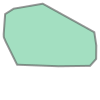

In [145]:
get_isochrone(location_lon, location_lat)
